# Sequence to sequence learning for performing number addition

**Author:** [Smerity](https://twitter.com/Smerity) and others<br>
**Date created:** 2015/08/17<br>
**Last modified:** 2020/04/17<br>
**Description:** A model that learns to add strings of numbers, e.g. "535+61" -> "596".

## Introduction

In this example, we train a model to learn to add two numbers, provided as strings.

**Example:**

- Input: "535+61"
- Output: "596"

Input may optionally be reversed, which was shown to increase performance in many tasks
 in: [Learning to Execute](http://arxiv.org/abs/1410.4615) and
[Sequence to Sequence Learning with Neural Networks](

 http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)

Theoretically, sequence order inversion introduces shorter term dependencies between
 source and target for this problem.

**Results:**

For two digits (reversed):

+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs

Three digits (reversed):

+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs

Four digits (reversed):

+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs

Five digits (reversed):

+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs


## Setup


In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True

# Maximum length of input is 'int + int' (e.g., '345+678'). Maximum length of
# int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS


## Generate the data


In [2]:

class CharacterTable:
    """Given a set of characters:
    + Encode them to a one-hot integer representation
    + Decode the one-hot or integer representation to their character output
    + Decode a vector of probabilities to their character output
    """

    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One-hot encode given string C.
        # Arguments
            C: string, to be encoded.
            num_rows: Number of rows in the returned one-hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        """Decode the given vector or 2D array to their character output.
        # Arguments
            x: A vector or a 2D array of probabilities or one-hot representations;
                or a vector of character indices (used with `calc_argmax=False`).
            calc_argmax: Whether to find the character index with maximum
                probability, defaults to `True`.
        """
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[x] for x in x)


# All the numbers, plus sign and space for padding.
chars = "0123456789+ "
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print("Generating data...")
while len(questions) < TRAINING_SIZE:
    f = lambda: int(
        "".join(
            np.random.choice(list("0123456789"))
            for i in range(np.random.randint(1, DIGITS + 1))
        )
    )
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = "{}+{}".format(a, b)
    query = q + " " * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += " " * (DIGITS + 1 - len(ans))
    if REVERSE:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print("Total questions:", len(questions))


Generating data...
Total questions: 50000


## Vectorize the data


In [3]:
print("Vectorization...")
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print("Training Data:")
print(x_train.shape)
print(y_train.shape)

print("Validation Data:")
print(x_val.shape)
print(y_val.shape)


Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


## Build the model


In [4]:
print("Build model...")
num_layers = 1  # Try to add more LSTM layers!

model = keras.Sequential()
# "Encode" the input sequence using a LSTM, producing an output of size 128.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(layers.LSTM(128, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last output of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(num_layers):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(layers.LSTM(128, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.Dense(len(chars), activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
dense (Dense)                (None, 4, 12)             1548      
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


## Train the model


In [5]:
epochs = 30
batch_size = 32


# Train the model each generation and show predictions against the validation
# dataset.
for epoch in range(1, epochs):
    print()
    print("Iteration", epoch)
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=1,
        validation_data=(x_val, y_val),
    )
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = np.argmax(model.predict(rowx), axis=-1)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print("Q", q[::-1] if REVERSE else q, end=" ")
        print("T", correct, end=" ")
        if correct == guess:
            print("☑ " + guess)
        else:
            print("☒ " + guess)



Iteration 1
1407/1407 [==============================] - 26s 16ms/step - loss: 1.7628 - accuracy: 0.3544 - val_loss: 1.5606 - val_accuracy: 0.4184
Q 24+954  T 978  ☒ 909 
Q 103+314 T 417  ☒ 699 
Q 14+989  T 1003 ☒ 909 
Q 288+103 T 391  ☒ 399 
Q 843+162 T 1005 ☒ 109 
Q 876+0   T 876  ☒ 877 
Q 387+59  T 446  ☒ 399 
Q 6+474   T 480  ☒ 155 
Q 11+14   T 25   ☒ 11  
Q 927+4   T 931  ☒ 909 

Iteration 2
1407/1407 [==============================] - 23s 17ms/step - loss: 1.3563 - accuracy: 0.4934 - val_loss: 1.2075 - val_accuracy: 0.5465
Q 4+709   T 713  ☒ 702 
Q 51+235  T 286  ☒ 288 
Q 257+237 T 494  ☒ 509 
Q 582+862 T 1444 ☒ 1544
Q 148+1   T 149  ☒ 156 
Q 20+160  T 180  ☒ 176 
Q 863+805 T 1668 ☒ 1608
Q 246+952 T 1198 ☒ 1200
Q 57+733  T 790  ☒ 888 
Q 84+459  T 543  ☒ 528 

Iteration 3
1407/1407 [==============================] - 22s 15ms/step - loss: 1.0419 - accuracy: 0.6152 - val_loss: 0.9501 - val_accuracy: 0.6510
Q 7+806   T 813  ☒ 815 
Q 942+53  T 995  ☒ 900 
Q 58+28   T 86   ☒ 80  
Q 29

You'll get to 99+% validation accuracy after ~30 epochs.


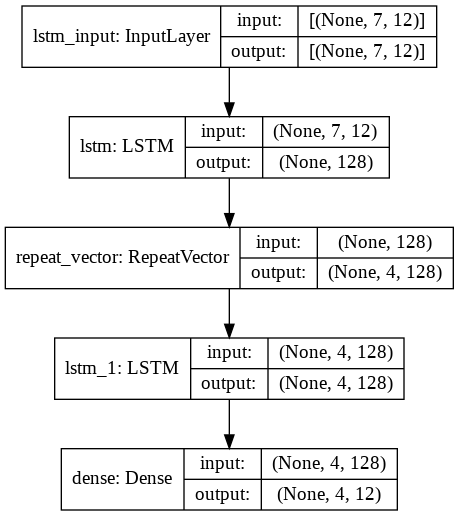

In [7]:
keras.utils.plot_model(model,'Addition_RNN.png',show_shapes=True)

## Evaluate the model

In [9]:
test_loss,test_accuracy=model.evaluate(x_val,y_val)

157/157 [==============================] - 1s 5ms/step - loss: 0.0046 - accuracy: 0.9994


In [12]:
x_train[0]

array([[ True, False, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
         True, False, False],
       [False, False, False, False, False,  True, False, False, False,
        False, False, False],
       [False, False, False, False,  True, False, False, False, False,
        False, False, False],
       [False,  True, False, False, False, False, False, False, False,
        False, False, False],
       [False, False, False, False, False, False, False, False, False,
         True, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False,  True]])

In [13]:
y_train[0]

array([[False, False, False, False, False,  True, False, False, False,
        False, False, False],
       [False, False, False, False, False,  True, False, False, False,
        False, False, False],
       [False, False, False, False, False, False,  True, False, False,
        False, False, False],
       [ True, False, False, False, False, False, False, False, False,
        False, False, False]])